# CNN Development

## Initial setup

### Import zone

Running this cell for the first time may take several seconds, since the physics backend is coded with JIT-compilable functions for greater performance, and their compilation takes place during import.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

import os
from CNN_testing import model_test
from termcolor import cprint
import pathlib
from datetime import datetime
import humanize

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image
# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision.datasets import KMNIST
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.utils.data import random_split

from torchvision import transforms, utils, datasets
import pathlib
import time

from ipywidgets import interact, fixed
import Hubbard_aux as aux
from Loaders import Importer
from Models import CNN_SSH_Basic, LeNet, CNN_SSH_Ania, CNN_SSH_Kacper, CNN_Upgrade
from CNN_dev import train_model, plot_training_hist, test_model, get_preds_from_model, get_labels_comparison_fig, get_CAM, CAMs_viz
from CAM_Sal_viz_utils import models_viz_datagen, CAMs_Sal_Viz

### Dataset downloading


Datasets used here are too powerful to be distributed all in git. Therefore they are shared separately.
This is how to obtain all the necessary dataset files, along with folder structure.

Files can be found at [this link](https://drive.google.com/drive/folders/1-13Wwsi7yukRb3QafZ5i7_CfjT8hTBjR?usp=share_link)

Structure:

```
📦Datasets
 ┣ 📂M=50
 ┃ ┣ 📂1000-200-100
 ┃ ┃ ┣ 📜test_set.pickle
 ┃ ┃ ┣ 📜training_set.pickle
 ┃ ┃ ┗ 📜validation_set.pickle
 ┃ ┣ 📂2000-400-200
 ┃ ┃ ┣ 📜test_set(1).pickle
 ┃ ┃ ┣ 📜test_set.pickle
 ┃ ┃ ┣ 📜training_set.pickle
 ┃ ┃ ┗ 📜validation_set.pickle
 ┃ ┣ 📂5000-1000-500
 ┃ ┃ ┣ 📜test_set.pickle
 ┃ ┃ ┣ 📜training_set.pickle
 ┃ ┃ ┗ 📜validation_set.pickle
 ┃ ┣ 📂W=0.01-500-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┣ 📂W=0.05-500-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┣ 📂W=0.15-200-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┣ 📂W=0.15-500-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┣ 📂W=1-200-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┣ 📂W=1-500-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┣ 📂W=3-200-samples
 ┃ ┃ ┣ 📜test_set(1).pickle
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┗ 📂W=3-500-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┣ 📂M=80
 ┃ ┣ 📂1000-200-100
 ┃ ┃ ┣ 📜test_set.pickle
 ┃ ┃ ┣ 📜training_set.pickle
 ┃ ┃ ┗ 📜validation_set.pickle
 ┃ ┣ 📂2000-400-200
 ┃ ┃ ┣ 📜test_set.pickle
 ┃ ┃ ┣ 📜training_set.pickle
 ┃ ┃ ┗ 📜validation_set.pickle
 ┃ ┣ 📂5000-1000-500
 ┃ ┃ ┣ 📜test_set.pickle
 ┃ ┃ ┣ 📜training_set.pickle
 ┃ ┃ ┗ 📜validation_set.pickle
 ┃ ┣ 📂W=0.01-500-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┣ 📂W=0.05-500-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┣ 📂W=0.15-500-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┣ 📂W=1-500-samples
 ┃ ┃ ┗ 📜test_set.pickle
 ┃ ┗ 📂W=3-500-samples
 ┃   ┗ 📜test_set.pickle
 ┗ 📜readme.md
 ```

### Hyperparameters and control variables setting

* `def_batch_size` $\to$ sets the size of single bqatch of samples given to CNN for training step,
* `epochs` $\to$ sets default trainig length (TODO: Add early stopping maybe?),
* `lr` $\to$ hyperparameter controlling CNN learging rate, a.k.a. leap size in SGD of loss function,
* `moment` $\to$ hyperparameter adding 'momentum' to SGD, which helps in escaping local loss function minima.

In [2]:
def_batch_size = 250
epochs = 100

lr = 0.001
moment = 0.99
# ==============================================================================
# Here we only have two classes, defined by Winding number:
# Winding number = 0
# Winding number = 1
# ==============================================================================
num_classes = 2 
class_names = ["Trivial", "Topological"]

### Device and datsets definition

Here we tell the computer to look for avaliable CUDA-enabled graphics card, or MPS backend (Apple M1 preferred backend), This allows for faster CNN training.  

---  

The second line refers to the previously-generated datasets we will use for CNN training. For inner workings of dataset generation please refer to [Data_generation.py](./Data_Generation.py).   
For the time being it may still be described quite messy, but it problably be thoroughly commented at later point in time, or adapted into a Jupyter notebook of its own for clearer description.  
At the moment we use a 5000-1000-500 dataset composition, which translates into:
* 5000 training samples
* 1000 validation samples
* 500 test samples

The routine described below demonstrated for M=50 sites chain, and the training/validation if performed on clean data (W=0).

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
ds_path = pathlib.Path("./Datasets/M=50/5000-1000-500/")

#### Torch.dataset asignment
For more comfortable UX down the road, training/validation/test datasets were developed as classes inheriting from torch.Dataset parent class, and need to be loaded from disk using Importer object, which is defined in [Loaders.py](./Loaders.py) file.

In [4]:
ds = Importer(ds_path, def_batch_size)
train_loader = ds.get_train_loader(seed=2137)
val_loader = ds.get_val_loader()
test_loader = ds.get_test_loader()

### Model definition
The model we are using is defined in [Models.py](./Models.py) file. At the moment, the model of choice is `CNN_Upgrade`, but its name or structure may be subject to change.  
As of now we settled for using SGD + momentum combination in our model.

In [5]:
model  = CNN_Upgrade()
model_load = False
if model_load:
    model_name = 'upgraded_model_x'
    model.load_state_dict(torch.load(f"Models/{model_name}.dict"))
    # with open(f"./Models/{model_name}_history.pickle", "rb") as f:
    #     train_history = pickle.load(f)

model = model.float()
model.to(device);
optimizer = optim.SGD(model.parameters(), 
                      lr=lr, 
                      momentum=moment, 
                      weight_decay=0.1)

## CNN Training

In [7]:
if not model_load:
    train_history = train_model(model, epochs, train_loader, val_loader, 
                                    optimizer, def_batch_size, num_classes,
                                    print_all=True)

[INFO] training the network...
[INFO] EPOCH: 1/100
Train loss: 0.687776, Train accuracy: 0.5000
 Val  loss: 0.693427,  Val  accuracy: 0.5000

[INFO] EPOCH: 2/100
Train loss: 0.657810, Train accuracy: 0.5002
 Val  loss: 0.699974,  Val  accuracy: 0.5000

[INFO] EPOCH: 3/100
Train loss: 0.622808, Train accuracy: 0.8302
 Val  loss: 0.720788,  Val  accuracy: 0.5000

[INFO] EPOCH: 4/100
Train loss: 0.592452, Train accuracy: 0.9120
 Val  loss: 0.720233,  Val  accuracy: 0.5000

[INFO] EPOCH: 5/100
Train loss: 0.561644, Train accuracy: 0.8838
 Val  loss: 0.689003,  Val  accuracy: 0.5000

[INFO] EPOCH: 6/100
Train loss: 0.525326, Train accuracy: 0.9574
 Val  loss: 0.669079,  Val  accuracy: 0.5000

[INFO] EPOCH: 7/100
Train loss: 0.489442, Train accuracy: 0.9942
 Val  loss: 0.659319,  Val  accuracy: 0.5000

[INFO] EPOCH: 8/100
Train loss: 0.463819, Train accuracy: 0.9988
 Val  loss: 0.643925,  Val  accuracy: 0.5000

[INFO] EPOCH: 9/100
Train loss: 0.444103, Train accuracy: 1.0000
 Val  loss: 0.65

### Model saving

Now we can save the trained model to disk for further evaluation, and performance testing. We use name `upgraded_model_x` as a temporary filename, which gets overwritten with every trained model, but gets changed once the model proves to be robust in disordered cases.

In [8]:
# serialize the model to disk
if not model_load:
    fname = 'upgraded_model_x'
    torch.save(model.state_dict(), f"Models/{fname}.dict")
    torch.save(train_history, f"Models/{fname}_history.pickle")

## Model testing

### Clean case

First let's test the model on clean test dataset. Independent from the training and validation datasets, but also clean. 

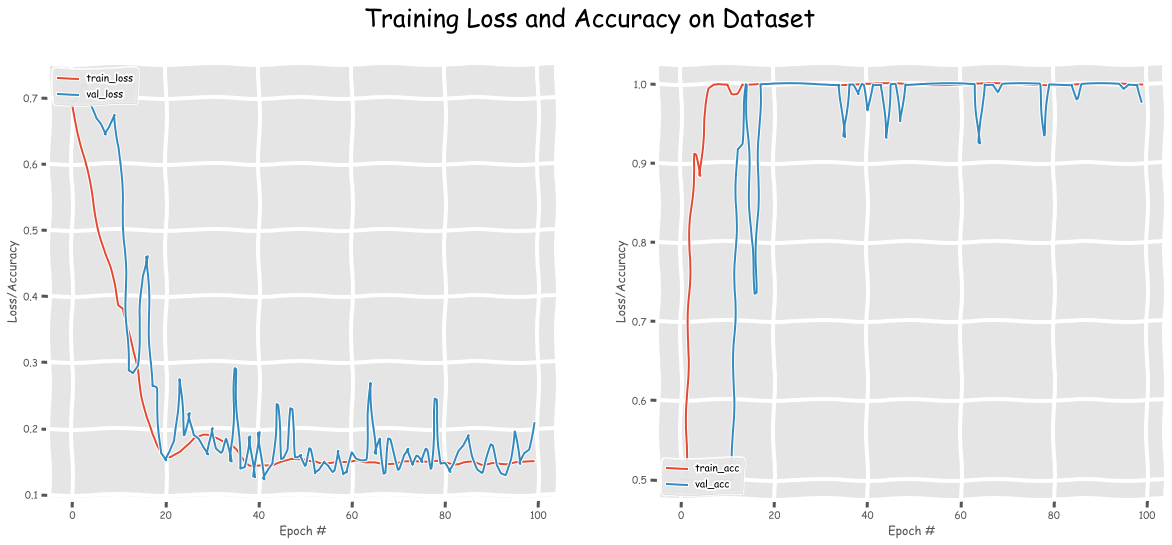

In [9]:
with plt.xkcd():
    plot_training_hist(train_history)

And let's compare the predicted labels with true ones

[INFO] evaluating network...
              precision    recall  f1-score   support

     Trivial       1.00      0.77      0.87       250
 Topological       0.81      1.00      0.90       250

    accuracy                           0.88       500
   macro avg       0.91      0.88      0.88       500
weighted avg       0.91      0.88      0.88       500



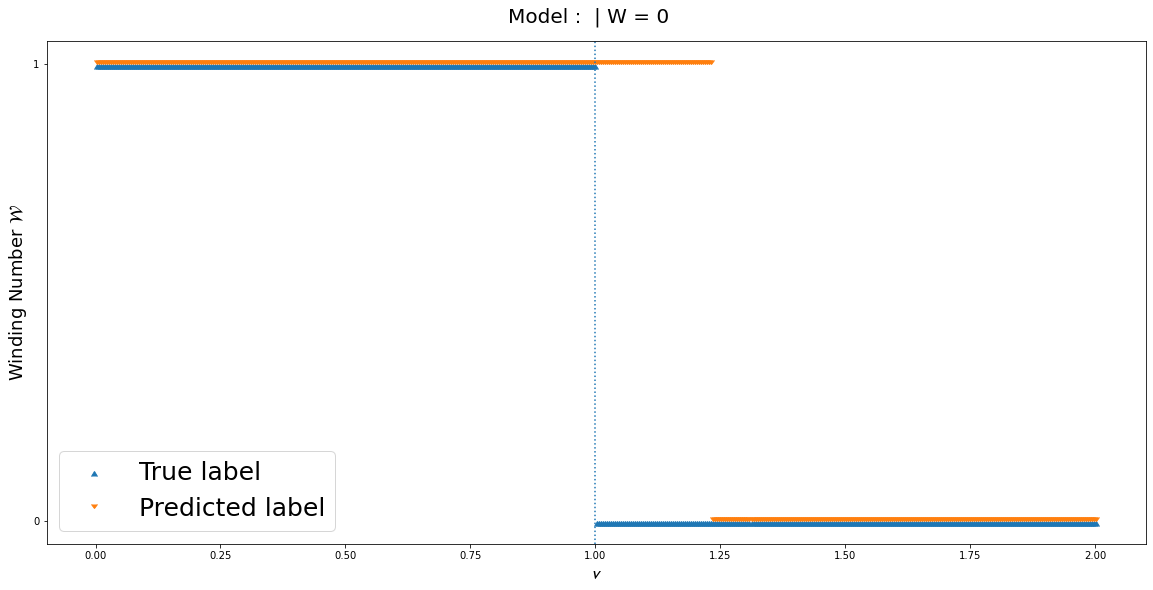

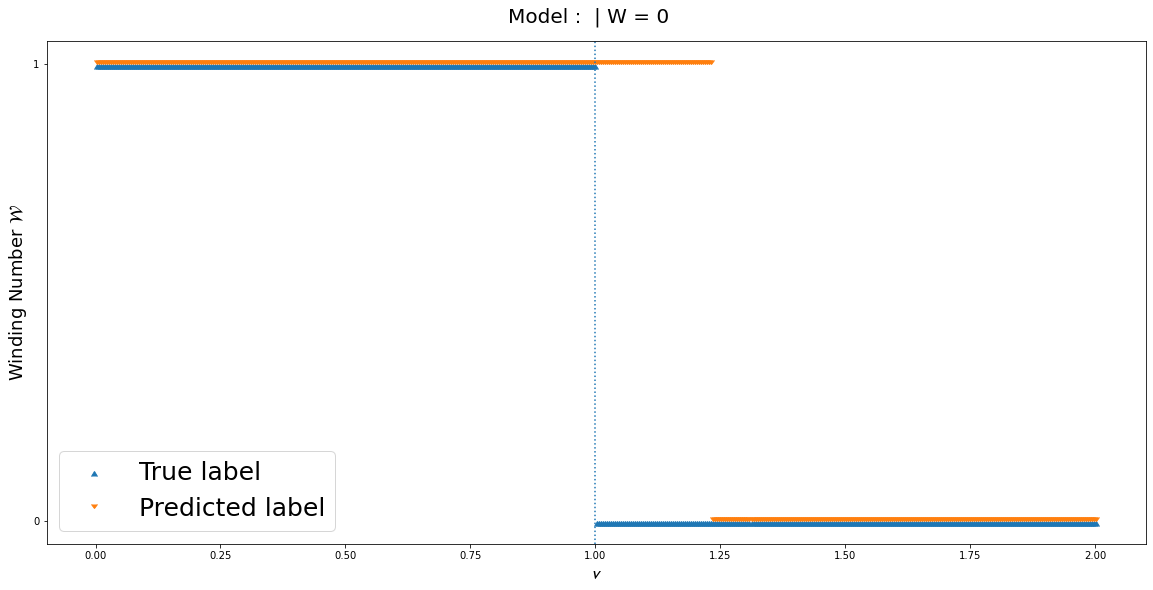

In [10]:
preds = get_preds_from_model(model, test_loader, class_names, device)
test_dict = test_model(model, test_loader, class_names, device)
    
# with plt.xkcd():
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
get_labels_comparison_fig(fig, ax, ds, preds)

### Disordered case

#### W = 1

In [11]:
ds_path_w1 = pathlib.Path("./Datasets/M=50/W=1-200-samples/")
ds_w1 = Importer(ds_path_w1, def_batch_size)
test_loader_w1 = ds_w1.get_test_loader()
preds_w1 = get_preds_from_model(model, test_loader_w1, class_names, device)

[INFO] evaluating network...
              precision    recall  f1-score   support

     Trivial       0.00      0.00      0.00        97
 Topological       0.52      1.00      0.68       103

    accuracy                           0.52       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.27      0.52      0.35       200



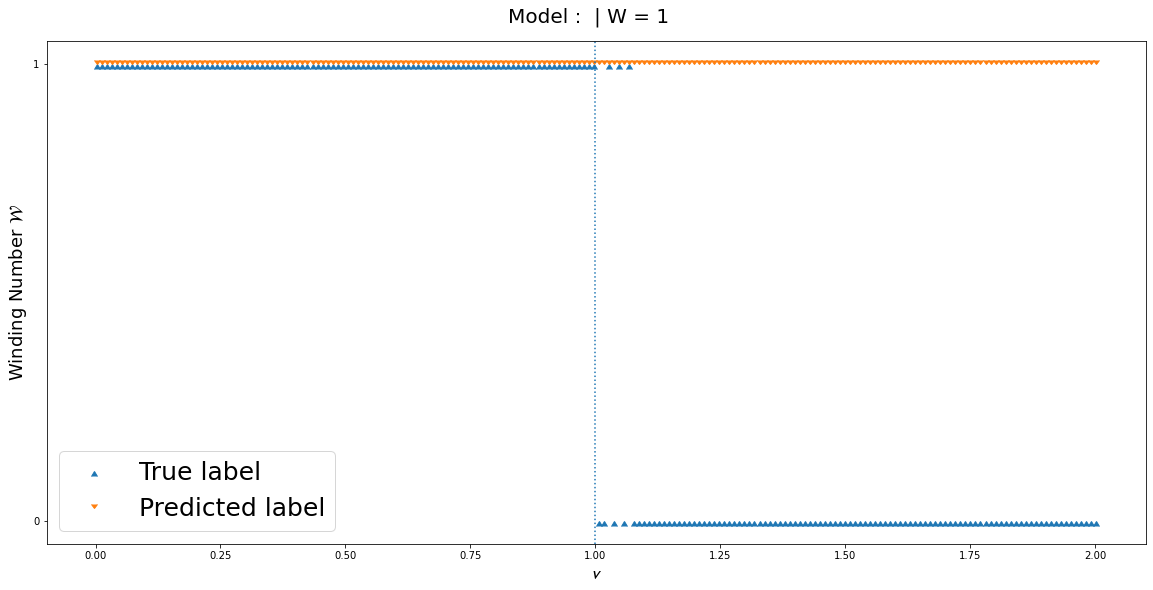

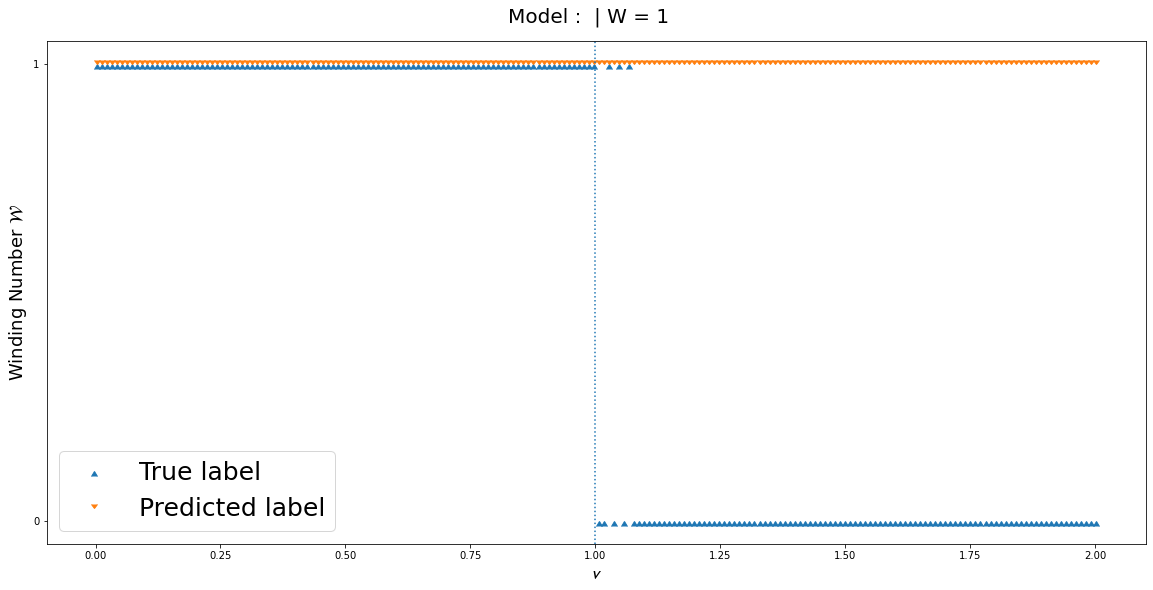

In [12]:
test_dict = test_model(model, test_loader_w1, class_names, device)

# with plt.xkcd():
fig_w1, ax_w1 = plt.subplots(1, 1, figsize=(16, 8))
get_labels_comparison_fig(fig_w1, ax_w1, ds_w1, preds_w1)

#### W = 3

In [13]:
ds_path_w3 = pathlib.Path("./Datasets/M=50/W=3-200-samples/")
ds_w3 = Importer(ds_path_w3, def_batch_size)
test_loader_w3 = ds_w3.get_test_loader()
preds_w3 = get_preds_from_model(model, test_loader_w3, class_names, device)

[INFO] evaluating network...
              precision    recall  f1-score   support

     Trivial       0.00      0.00      0.00        77
 Topological       0.61      1.00      0.76       123

    accuracy                           0.61       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.38      0.61      0.47       200



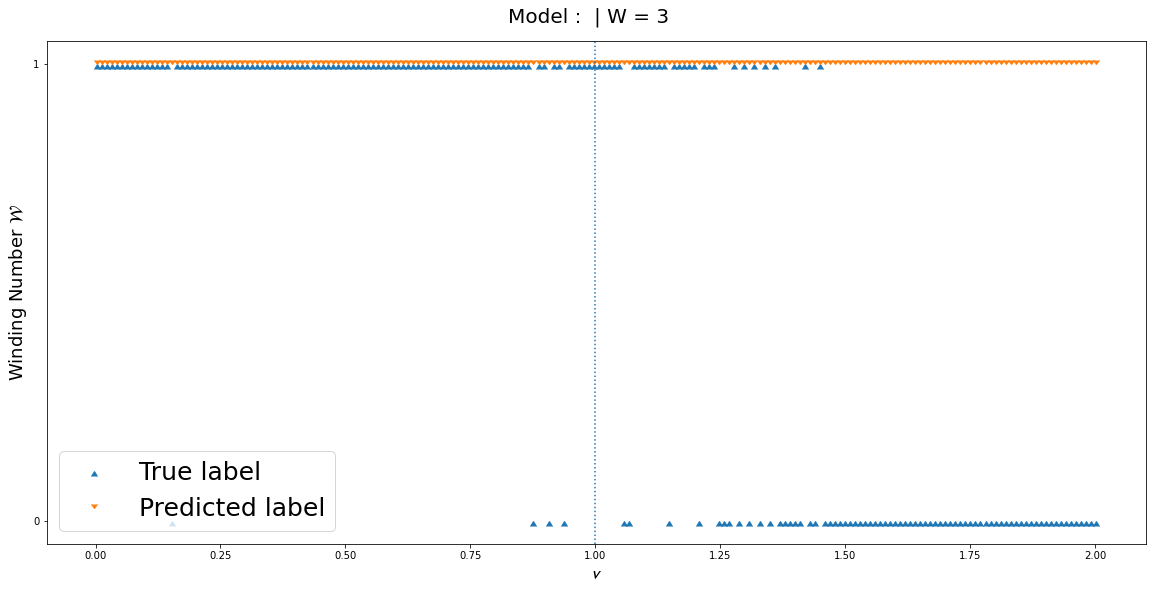

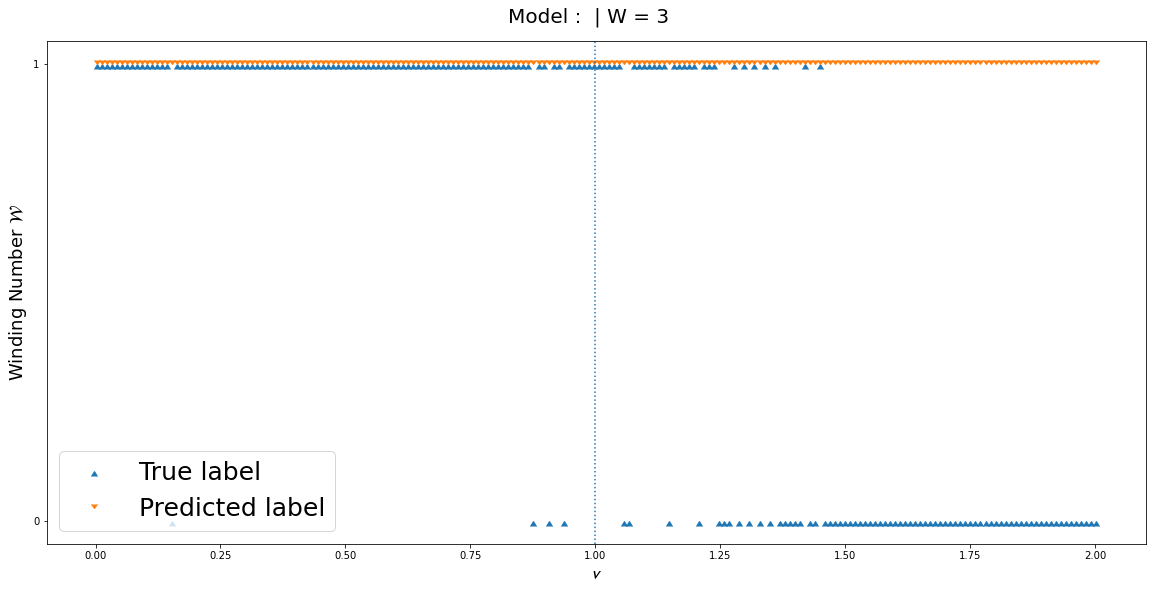

In [14]:
test_dict = test_model(model, test_loader_w3, class_names, device)

# with plt.xkcd():
fig_w3, ax_w3 = plt.subplots(1, 1, figsize=(16, 8))
get_labels_comparison_fig(fig_w3, ax_w3, ds_w3, preds_w3)

### Model interpretation

#### CAM

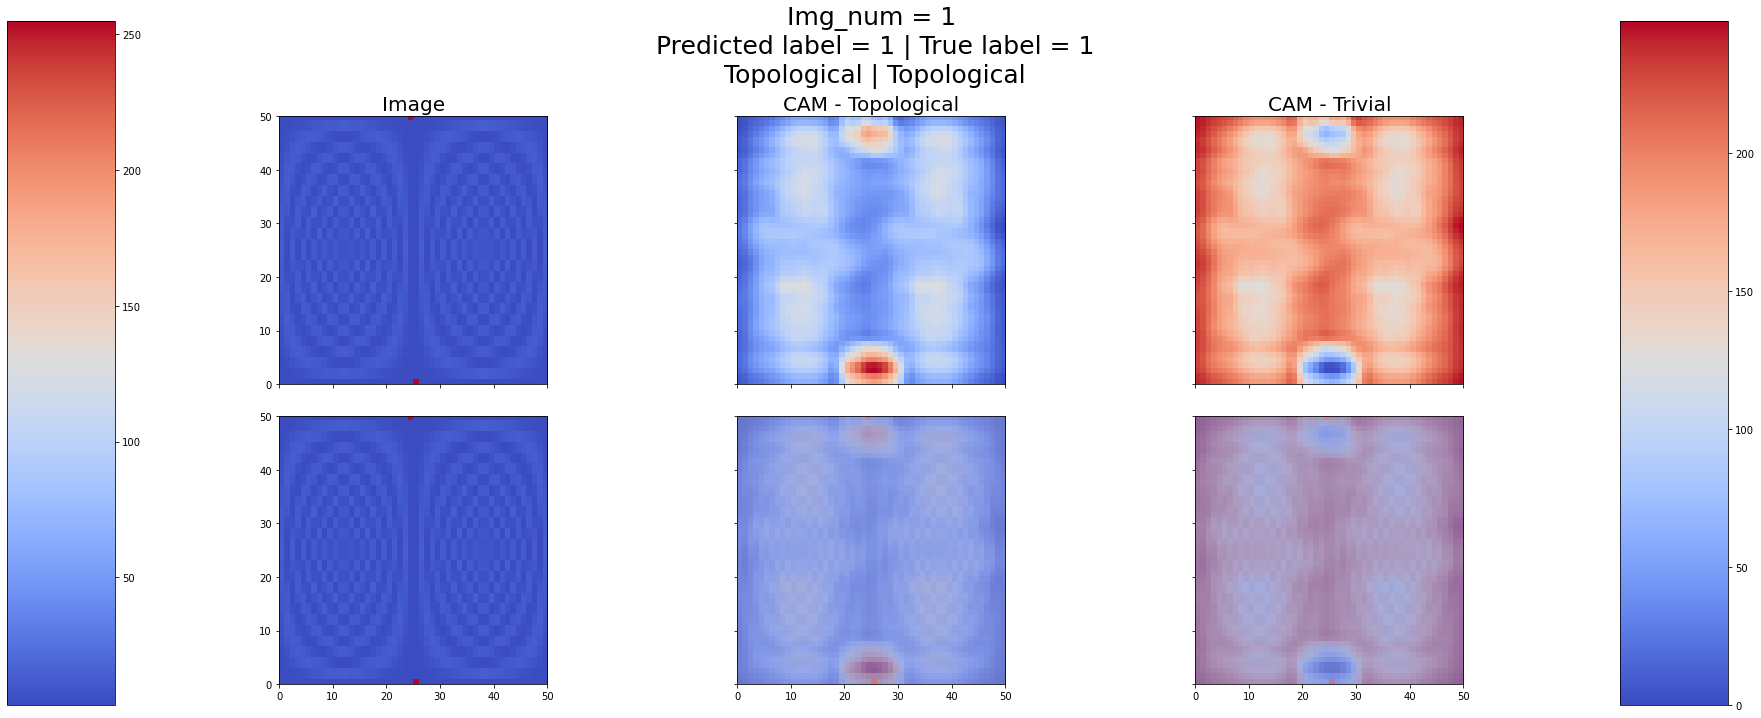

In [15]:
cam_img_num = 1

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

CAMs_topo, CAMs_trivial = get_CAM(model, ds, cam_img_num=cam_img_num)
            
CAMs_viz(fig, ax, [CAMs_topo, CAMs_trivial], ds, preds, cam_img_num=cam_img_num, M=50)